<a href="https://colab.research.google.com/github/salmankhaliq22/10-Time-Series-Analysis/blob/main/Project_2_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [11]:
# importing libraries
import pandas as pd
import numpy as np
# yfinance is where we will pull our data from
import yfinance as yf
import matplotlib.pyplot as plt

# pulling data of APPL stock from start of 2010 till now
# if we do not put in the end date then by default it would be today's date
df = yf.download('AAPL', start = '2010-01-01')

# looking at the first five rows of the data
print(df.head())
print('\n Shape of the data:')
print(df.shape)

# # setting the index as date
# df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
# df.index = df['Date']

# #creating dataframe with date and the target variable
# data = df.sort_index(ascending=True, axis=0)
# new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])


[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.535086  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.546383  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.442255  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.430346  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.473095  447610800

 Shape of the data:
(3135, 6)


In [5]:
# NOTE: While splitting the data into train and validation set, we cannot use random splitting since that will destroy the time component. So here we have set the last year’s data into validation and the 4 years’ data before that into train set.

# splitting into train and validation
train = df[:2520]
valid = df[2520:]

## Moving Average Strategy

In [8]:
# shapes of training set
print('\n Shape of training set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)

# In the next step, we will create predictions for the validation set and check the RMSE using the actual values.
# making predictions
preds = []
for i in range(0,valid.shape[0]):
    a = train['Close'][len(train)-252+i:].sum() + sum(preds)
    b = a/248
    preds.append(b)


# checking the results (RMSE value)
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
print('\n RMSE value on validation set:')
print(rms)


 Shape of training set:
(2520, 6)

 Shape of validation set:
(615, 6)

 RMSE value on validation set:
45.882328633336996


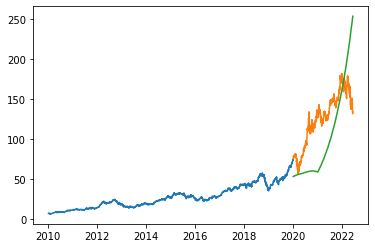

In [12]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

## Linear Regression

In [25]:
X_train = train.drop('Close', axis=1)
y_train = train['Close']
X_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [15]:
pipelines = {
    'rf':make_pipeline(RandomForestRegressor(random_state=1234)),
    'gb':make_pipeline(GradientBoostingRegressor(random_state=1234)),
    'ridge':make_pipeline(Ridge(random_state=1234)),
    'lasso':make_pipeline(Lasso(random_state=1234)),
    'enet':make_pipeline(ElasticNet(random_state=1234)),
}

In [16]:
hypergrid = {
    'rf': {
        'randomforestregressor__n_estimators':[100],
        'randomforestregressor__min_samples_split':[2,4,6],
        'randomforestregressor__oob_score':[True, False],
        'randomforestregressor__min_samples_leaf':[1,2,3]
    },
    'gb':{
        'gradientboostingregressor__n_estimators':[100,200,300],
        'gradientboostingregressor__subsample':[0.6,0.7,0.8],                         # stochastic gradient boosting
        'gradientboostingregressor__max_features':[None, 1, 2],
        'gradientboostingregressor__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'ridge':{
        'ridge__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'lasso':{
        'lasso__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'enet':{
        'elasticnet__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    }
}

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError

In [20]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hypergrid[algo], cv=10, n_jobs=-1)
    try:
        print('Starting training for {}.'.format(algo))
        model.fit(X_train, y_train)
        fit_models[algo] = model
        print('{} has been successfully fit.'.format(algo))
    except NotFittedError as e:
        print(repr(e))

Starting training for rf.
rf has been successfully fit.
Starting training for gb.
gb has been successfully fit.
Starting training for ridge.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.95013e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


ridge has been successfully fit.
Starting training for lasso.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.487e+01, tolerance: 5.049e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


lasso has been successfully fit.
Starting training for enet.
enet has been successfully fit.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e+02, tolerance: 5.049e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


## Evaluation

In [31]:
X_valid.drop('Predictions', axis = 1, inplace=True)

In [32]:
from sklearn.metrics import r2_score, mean_absolute_error

In [33]:
for algo,model in fit_models.items():
    yhat = model.predict(X_valid)
    print('{} scores - R2:{} MAE:{}'.format(algo, r2_score(y_valid, yhat), mean_absolute_error(y_valid, yhat)))

rf scores - R2:-2.6658086830649204 MAE:52.52994850053244
gb scores - R2:-2.6278340614063977 MAE:52.193286968697116
ridge scores - R2:0.9991426855212517 MAE:0.6839165311667375
lasso scores - R2:0.9975129458167797 MAE:1.1890424696028612
enet scores - R2:0.9978235216626535 MAE:1.1157059431389025


In [40]:
# import multiple models 
from time import time
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score
import seaborn as sns

# create a list of these models
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()]

In [38]:
# loops through models and record their performance 
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_valid)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_valid, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_valid, y_pred))
    print("\tR2 score:", r2_score(y_valid, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.010s
	Prediction time: 0.004s
	Explained variance: 0.16479096637677126
	Mean absolute error: 87.38286455309488
	R2 score: -7.409904688730878

GradientBoostingRegressor()
	Training time: 0.465s
	Prediction time: 0.003s
	Explained variance: 0.06751920563567648
	Mean absolute error: 52.2239048942793
	R2 score: -2.630959365795938

KNeighborsRegressor()
	Training time: 0.004s
	Prediction time: 0.007s
	Explained variance: 0.16479096637677126
	Mean absolute error: 87.38286455309488
	R2 score: -7.409904688730878

ExtraTreesRegressor()
	Training time: 0.591s
	Prediction time: 0.020s
	Explained variance: 0.06608596069638528
	Mean absolute error: 52.27049044421436
	R2 score: -2.6367255211462193

RandomForestRegressor()
	Training time: 1.400s
	Prediction time: 0.018s
	Explained variance: 0.06437454313679325
	Mean absolute error: 52.4518752043189
	R2 score: -2.6566465050096455

DecisionTreeRegressor()
	Training time: 0.022s
	Prediction time: 0.002s
	Explained

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.559e+01, tolerance: 5.049e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.00429e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


ValueError: ignored

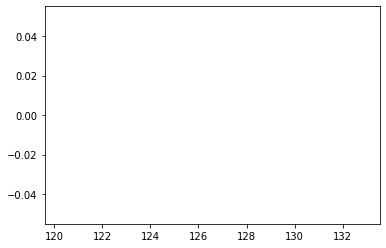

In [42]:
# observe the results
sns.distplot(y_pred,y_valid)

In [43]:
# define all the parameters for this model:
parameters = { 'loss' : ['ls', 'lad', 'huber', 'quantile'],
              'learning_rate' : (0.05,0.25,0.50,1),
              'criterion' : ['friedman_mse', 'mse', 'mae'],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

In [46]:
# engage the GridSearch and record the best parameters and best estimator
grid = GridSearchCV(GradientBoostingRegressor(),parameters)
model = grid.fit(X_train, y_train)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist

{'criterion': 'mae', 'learning_rate': 0.5, 'loss': 'lad', 'max_features': 'log2'} 

GradientBoostingRegressor(criterion='mae', learning_rate=0.5, loss='lad',
                          max_features='log2') 



/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


In [47]:
best_model = GradientBoostingRegressor(learning_rate=0.5, loss='lad', max_features='log2')

In [51]:
# this ignores the depreciation warnings etc
import warnings
warnings.filterwarnings("ignore")

In [ ]:
start = time()
model.fit(X_train, y_train)
train_time = time() - start
start = time()
y_pred = best_model.predict(X_valid)
predict_time = time()-start    
print(model)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_valid, y_pred))
print("\tMean absolute error:", mean_absolute_error(y_valid, y_pred))
print("\tR2 score:", r2_score(y_valid, y_pred))
print()

## Facebook Prophet

In [ ]:
#importing prophet
from fbprophet import Prophet

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

In [ ]:
#rmse
forecast_valid = forecast['yhat'][2520:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

In [ ]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
Results
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms



In [ ]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])